In [8]:
%pip install -U langgraph langchain_google_genai 

     ---------------------------------------- 0.0/133.6 kB ? eta -:--:--
     -------- ---------------------------- 30.7/133.6 kB 640.0 kB/s eta 0:00:01
     -------- ---------------------------- 30.7/133.6 kB 640.0 kB/s eta 0:00:01
     ----------------- ------------------- 61.4/133.6 kB 363.1 kB/s eta 0:00:01
     ------------------------- ----------- 92.2/133.6 kB 476.3 kB/s eta 0:00:01
     ------------------------- ----------- 92.2/133.6 kB 476.3 kB/s eta 0:00:01
     ------------------------------------ 133.6/133.6 kB 463.7 kB/s eta 0:00:00
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.3.5
    Uninstalling langgraph-0.3.5:
      Successfully uninstalled langgraph-0.3.5
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image

class State(TypedDict):
    state: str
    
class ReturnNodeValue():
    def __init__(self,node_secret:str):
        self._value = node_secret
        
    def __call__(self,state:State):
        print(f"Adding {self._value} to {state['state']}")
        return {"state":[self._value]}
    
builder = StateGraph(State)

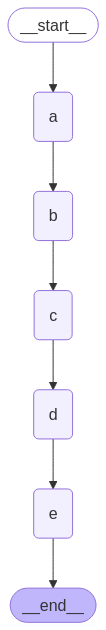

In [2]:
builder.add_node("a",ReturnNodeValue("I'm A"))
builder.add_node("b",ReturnNodeValue("I'm B"))
builder.add_node("c",ReturnNodeValue("I'm C"))
builder.add_node("d",ReturnNodeValue("I'm D"))
builder.add_node("e",ReturnNodeValue("I'm E"))


builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("b","c")
builder.add_edge("c","d")
builder.add_edge("d","e")
builder.add_edge("e",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"state":[]})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]
Adding I'm E to ["I'm D"]


{'state': ["I'm E"]}

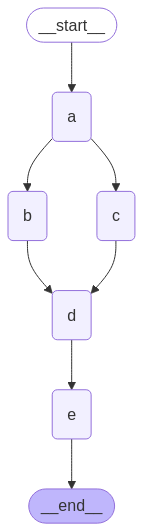

In [4]:
builder = StateGraph(State)


builder.add_node("a",ReturnNodeValue("I'm A"))
builder.add_node("b",ReturnNodeValue("I'm B"))
builder.add_node("c",ReturnNodeValue("I'm C"))
builder.add_node("d",ReturnNodeValue("I'm D"))
builder.add_node("e",ReturnNodeValue("I'm E"))


builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("c","d")
builder.add_edge("b","d")
builder.add_edge("d","e")
builder.add_edge("e",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
import operator
from typing import Annotated


class State(TypedDict):
    state: Annotated[list,operator.add]

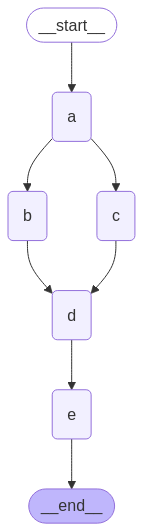

In [6]:
builder = StateGraph(State)


builder.add_node("a",ReturnNodeValue("I'm A"))
builder.add_node("b",ReturnNodeValue("I'm B"))
builder.add_node("c",ReturnNodeValue("I'm C"))
builder.add_node("d",ReturnNodeValue("I'm D"))
builder.add_node("e",ReturnNodeValue("I'm E"))


builder.add_edge(START,"a")
builder.add_edge("a","b")
builder.add_edge("a","c")
builder.add_edge("c","d")
builder.add_edge("b","d")
builder.add_edge("d","e")
builder.add_edge("e",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"state":[]})


Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Adding I'm E to ["I'm A", "I'm B", "I'm C", "I'm D"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E"]}

In [ ]:
class State(TypedDict):
    question:str
    answer:str
    context:Annotated[list,operator]

In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
_set_env("TAVILY_API_KEY")

In [22]:
%pip install -U langchain_community
%pip install wikipedia

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached wikipedia-1.4.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from langchain_google_genai import ChatGoogleGenerativeAI
_set_env("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, SystemMessage
def search_web(state):
    tavily_search = TavilySearchResults(max_result=3)
    search_docs = tavily_search.run(state["question"])
    
    formatted_search_docs = "\n\n---\n\n".join([f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs])
    
    return {"context":[formatted_search_docs]}

def search_wikipedia(state):
    search_docs = WikipediaLoader(query=state["question"],load_max_docs=2).load()
    
    formatted_search_docs = "\n\n---\n\n".join([f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page","")}"/>\n{doc.page_content}\n</Document>' for doc in search_docs])
    return {"context":[formatted_search_docs]}

def generate_answer(state):
    context=state["context"]
    question=state["question"]
    
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,context=context)
    
    answer = llm.invoke([SystemMessage(content=answer_instructions),HumanMessage(content=f"Answer The Question")])
    return {"answer":answer}

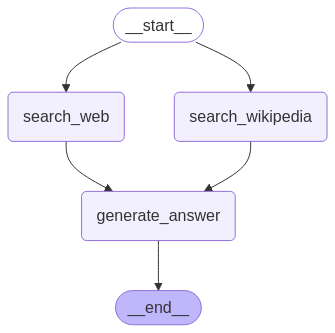

In [25]:
builder = StateGraph(State)

builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia",search_wikipedia)
builder.add_node("generate_answer",generate_answer)

builder.add_edge(START,"search_web")
builder.add_edge(START,"search_wikipedia")

builder.add_edge("search_web","generate_answer")
builder.add_edge("search_wikipedia","generate_answer")
builder.add_edge("generate_answer",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
result = graph.invoke({"question":"Who was the first child of zuckerburg"})
result['answer'].content

'Maxima Chan Zuckerberg was the first child of Mark Zuckerberg and Priscilla Chan.  She was born in December 2015.'